In [1]:
import csv
import os
import json
import codecs
import re
import pandas as pd

In [2]:
import xlrd

In [3]:
data = pd.read_excel('updated_bangla.xlsx')

In [4]:
data = list(data['text'])

In [5]:
import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [7]:
data_words = data.copy()

In [8]:
str(data_words[3]).split(' ')

['24', '', 'ডেঙ্গু', '', 'আক্রান্ত', 'যুবরাজকে', 'ছাড়াই', 'নামছে', 'ভারত', '']

In [9]:
tokenized_data = [str(data_words[i]).split(' ') for i in range(len(data_words))]

In [10]:
tokenized_data

[['',
  '',
  'ডেঙ্গু',
  '',
  'ডোঙ্গল',
  'লিখেছেন',
  '',
  '',
  'পোস্টটি',
  'করা',
  'হয়েছে',
  'বৃহস্পতিবার',
  '০৮',
  'জুলাই',
  '২০১০',
  '০২২৪৩৩',
  'পরিচ'],
 ['',
  '',
  'ডেঙ্গু',
  '',
  'ডোঙ্গল',
  'লিখেছেন',
  'আশাবাদী',
  'পোস্টটি',
  'করা',
  'হয়েছে',
  'শনিবার',
  '১০',
  'জুলাই',
  '২০১০',
  '২৩২৪৫৯',
  'ক্লাসিক্যাল',
  'ডেঙ্'],
 ['', '', 'আবার', '', 'ডেঙ্গু', 'জ্বর', '', 'সতর্ক', 'থাকুন', '', ''],
 ['24',
  '',
  'ডেঙ্গু',
  '',
  'আক্রান্ত',
  'যুবরাজকে',
  'ছাড়াই',
  'নামছে',
  'ভারত',
  ''],
 ['',
  '',
  '',
  'ডেঙ্গু',
  'জ্বরের',
  'সেবাযত্ন',
  'ডেঙ্গু',
  'কি',
  '১ডেঙ্গু',
  'একটি',
  'ভাইরাসজনিত',
  'জ্বর',
  'এডিস',
  'মশার',
  'মাধ্যমে',
  '',
  'ডেঙ্গু',
  'জ্বর',
  '',
  'ছড়ায়'],
 ['',
  '',
  '',
  'চারিদিকে',
  'প্রচুর',
  '',
  'ডেঙ্গু',
  '',
  'জ্বরের',
  'প্রকোপ',
  'বেড়েছে',
  '',
  'ডেঙ্গু',
  '',
  'কি',
  '১ডেঙ্গু',
  '',
  'একটি',
  'ভাইরাসজনিত',
  'জ্বর',
  'এডিস',
  'মশার',
  'মাধ্'],
 ['', '', '', '', 'ডেঙ্গু', ''],
 ['',
  '',
  '',
 

In [11]:
for i in range(len(tokenized_data)):
    while '' in tokenized_data[i]:
        tokenized_data[i].remove('')

In [12]:
data_words = tokenized_data.copy()

In [13]:
data_words

[['ডেঙ্গু',
  'ডোঙ্গল',
  'লিখেছেন',
  'পোস্টটি',
  'করা',
  'হয়েছে',
  'বৃহস্পতিবার',
  '০৮',
  'জুলাই',
  '২০১০',
  '০২২৪৩৩',
  'পরিচ'],
 ['ডেঙ্গু',
  'ডোঙ্গল',
  'লিখেছেন',
  'আশাবাদী',
  'পোস্টটি',
  'করা',
  'হয়েছে',
  'শনিবার',
  '১০',
  'জুলাই',
  '২০১০',
  '২৩২৪৫৯',
  'ক্লাসিক্যাল',
  'ডেঙ্'],
 ['আবার', 'ডেঙ্গু', 'জ্বর', 'সতর্ক', 'থাকুন'],
 ['24', 'ডেঙ্গু', 'আক্রান্ত', 'যুবরাজকে', 'ছাড়াই', 'নামছে', 'ভারত'],
 ['ডেঙ্গু',
  'জ্বরের',
  'সেবাযত্ন',
  'ডেঙ্গু',
  'কি',
  '১ডেঙ্গু',
  'একটি',
  'ভাইরাসজনিত',
  'জ্বর',
  'এডিস',
  'মশার',
  'মাধ্যমে',
  'ডেঙ্গু',
  'জ্বর',
  'ছড়ায়'],
 ['চারিদিকে',
  'প্রচুর',
  'ডেঙ্গু',
  'জ্বরের',
  'প্রকোপ',
  'বেড়েছে',
  'ডেঙ্গু',
  'কি',
  '১ডেঙ্গু',
  'একটি',
  'ভাইরাসজনিত',
  'জ্বর',
  'এডিস',
  'মশার',
  'মাধ্'],
 ['ডেঙ্গু'],
 ['মশা',
  'দিয়ে',
  'মশা',
  'নিধন',
  'স্ত্রী',
  'এডিস',
  'মশার',
  'কামড়েই',
  'ডেঙ্গু',
  'জ্বর',
  'হয়ে',
  'থাকে',
  'বিশ্ব',
  'স্বাস্থ্য',
  'সংস্থার',
  'হিসাবে',
  'ব'],
 ['ডেঙ্গু',
  'জ্বর',
  'রুখতে',
  'ব

In [14]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['ডেঙ্গু', 'ডোঙ্গল', 'লিখেছেন', 'পোস্টটি', 'করা', 'হয়েছে', 'বৃহস্পতিবার', '০৮', 'জুলাই', '২০১০', '০২২৪৩৩', 'পরিচ']


In [16]:

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:10])

[['ডেঙ্গু', 'ডোঙ্গল', 'লিখেছেন', 'হয়েছে', 'পরিচ'], ['ডেঙ্গু', 'আশাবাদী', 'হয়েছে'], ['ডেঙ্গু', 'জ্বর'], ['ডেঙ্গু', 'আক্রান্ত', 'যুবরাজকে', 'নামছে', 'ভারত'], ['ডেঙ্গু', 'সেবাযত্ন', 'ডেঙ্গু', 'একটি', 'ভাইরাসজনিত', 'জ্বর', 'এডিস', 'ডেঙ্গু', 'জ্বর'], ['ডেঙ্গু', 'বেড়েছে', 'ডেঙ্গু', 'একটি', 'ভাইরাসজনিত', 'জ্বর', 'এডিস', 'মাধ্'], ['ডেঙ্গু'], ['স্ত্রী', 'এডিস', 'জ্বর', 'হয়ে', 'সংস্থার', 'হিসাবে'], ['ডেঙ্গু', 'বিজ্ঞানীদের', 'সাফল্য', 'নানা', 'খবর'], ['ডেঙ্গু', 'বিজ্ঞানীদের', 'সাফল্য', 'নানা', 'খবর']]


In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(0, 1), (4, 1), (5, 1)], [(0, 1), (6, 1)], [(0, 1), (7, 1), (8, 1), (9, 1), (10, 1)], [(0, 3), (6, 2), (11, 1), (12, 1), (13, 1), (14, 1)], [(0, 2), (6, 1), (11, 1), (12, 1), (13, 1), (15, 1), (16, 1)], [(0, 1)], [(6, 1), (12, 1), (17, 1), (18, 1), (19, 1), (20, 1)], [(0, 1), (21, 1), (22, 1), (23, 1), (24, 1)], [(0, 1), (21, 1), (22, 1), (23, 1), (24, 1)]]


In [19]:
id2word[0]

'ডেঙ্গু'

In [20]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [21]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.000*"হবেডেংগুজ্বর" + 0.000*"সবথেকে" + 0.000*"প্রেসক্লাবে" + '
  '0.000*"ঘটিকায়" + 0.000*"বিষয়টা" + 0.000*"হলআমরা" + 0.000*"হাসিনাকে" + '
  '0.000*"ফিড়তে" + 0.000*"বহিরাগত" + 0.000*"বরণ"'),
 (1,
  '0.000*"হবেডেংগুজ্বর" + 0.000*"সবথেকে" + 0.000*"প্রেসক্লাবে" + '
  '0.000*"ঘটিকায়" + 0.000*"বিষয়টা" + 0.000*"হলআমরা" + 0.000*"হাসিনাকে" + '
  '0.000*"ফিড়তে" + 0.000*"বহিরাগত" + 0.000*"বরণ"'),
 (2,
  '0.950*"ডেঙ্গু" + 0.017*"এবং" + 0.003*"সব" + 0.000*"জন" + 0.000*"প্রতিরোধ" + '
  '0.000*"এক" + 0.000*"মিন্নি_রিফাত" + 0.000*"অভিযান" + 0.000*"মৃত্যু" + '
  '0.000*"চা_ঢালায়"'),
 (3,
  '0.323*"_" + 0.090*"উপর" + 0.045*"আগে" + 0.000*"প্রতিরোধ" + 0.000*"বার্তা" + '
  '0.000*"বিদেশ_খবর" + 0.000*"প্রথম_আলো_বন্ধুসভা" + 0.000*"থেকেই" + '
  '0.000*"নতুন" + 0.000*"ভরসা"'),
 (4,
  '0.252*"একটি" + 0.090*"খুব" + 0.000*"ঢাকার" + 0.000*"নিয়ন্ত্রণের" + '
  '0.000*"ভাইয়ের" + 0.000*"এক্ষেত্রে" + 0.000*"সিটি" + 0.000*"বিপদজনক" + '
  '0.000*"অন্যান্য" + 0.000*"নামই"'),
 (5,
  '0.307*"এই" + 0.000*"ন

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -19.992598025448252

Coherence Score:  0.40241158008562994


In [23]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\onyho\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


TypeError: Object of type complex is not JSON serializable

PreparedData(topic_coordinates=                               x                           y  topics  cluster  \
topic                                                                           
2       (-0.4905693242150713+0j)    (0.24613929082216743+0j)       1        1   
18       (-0.259295616611113+0j)    (-0.3682496745707197+0j)       2        1   
13     (-0.13922645916039098+0j)  (-0.042614327586236525+0j)       3        1   
17     (-0.14162053786027096+0j)   (-0.04492618620589571+0j)       4        1   
14      (0.04476146922516264+0j)    (0.01614069806703728+0j)       5        1   
9       (0.01391098796879944+0j)   (0.013659937961603672+0j)       6        1   
11      (0.04918505515390288+0j)   (0.016128836576882542+0j)       7        1   
15       (0.0548456673236545+0j)   (0.016134678606320833+0j)       8        1   
8       (0.04242287557841536+0j)   (0.015975789329975867+0j)       9        1   
6        (0.0737743820228393+0j)   (0.014292578159040092+0j)      10        1 

In [24]:
import os

In [25]:
os.environ['MALLET_HOME'] = 'C:\\mallet'

mallet_path = 'C:\\mallet\\bin\\mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [26]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(1,
  [('ডেঙ্গু', 0.37569246264898437),
   ('স্বাস্থ্য', 0.04230317273795535),
   ('টাকা', 0.04230317273795535),
   ('ছড়িয়ে_পড়েছে', 0.017122712774886688),
   ('ঔষধ', 0.016786973308712438),
   ('সারাদেশে', 0.016786973308712438),
   ('দরকার', 0.015611885177102568),
   ('দিনেই', 0.01527614571092832),
   ('পরীক্ষায়', 0.011079402383750209),
   ('নির্দেশ', 0.010240053718314587)]),
 (9,
  [('ডেঙ্গু', 0.4939271255060729),
   ('একটি', 0.03576248313090418),
   ('লক্ষণ', 0.033738191632928474),
   ('জেনে_নিন', 0.018724696356275303),
   ('সাতক্ষীরায়', 0.014844804318488529),
   ('পেলে_হয়ত', 0.013157894736842105),
   ('জ্বরের', 0.009784075573549258),
   ('নিয়ন্ত্রণে_সফল', 0.008097165991902834),
   ('কলকাতা_যেভাবে', 0.007928475033738192),
   ('মানুষের', 0.007928475033738192)]),
 (17,
  [('হাসপাতালে', 0.2598389302537608),
   ('জন', 0.1311350858532138),
   ('সংখ্যা', 0.10028870992250417),
   ('বাড়ছে', 0.054399027503418934),
   ('হাজার', 0.05014435496125209),
   ('২৪_ঘণ্টায়', 0.0197538368029174

In [27]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(12,
  [('ডেঙ্গু', 0.216703521006974),
   ('খুব', 0.029426773260758633),
   ('দেওয়া', 0.0226228950501786),
   ('তাহলে', 0.021092022452798096),
   ('করে', 0.020411634631740092),
   ('রস', 0.018710665079095083),
   ('হওয়ার', 0.01786018030277258),
   ('জরুরি', 0.017179792481714577),
   ('সবাইকে', 0.01547882292906957),
   ('দ্রুত', 0.015308725973805068)]),
 (19,
  [('এই', 0.08317057291666667),
   ('নতুন', 0.052734375),
   ('করে', 0.041829427083333336),
   ('আমরা', 0.040690104166666664),
   ('কিন্তু', 0.03955078125),
   ('দিয়ে', 0.028645833333333332),
   ('বাংলাদেশের', 0.027669270833333332),
   ('ডেঙ্গুর', 0.020670572916666668),
   ('বেড়ে', 0.019694010416666668),
   ('ধরনের', 0.017578125)]),
 (10,
  [('আক্রান্ত', 0.20520325203252032),
   ('হয়ে', 0.18910569105691058),
   ('যাবে', 0.04455284552845529),
   ('পেঁপে_পাতার', 0.042439024390243905),
   ('মারা', 0.04016260162601626),
   ('গেছে', 0.036422764227642276),
   ('সুস্থ', 0.025365853658536587),
   ('জ্বরের_প্রকোপ', 0.01658536585365853

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [29]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

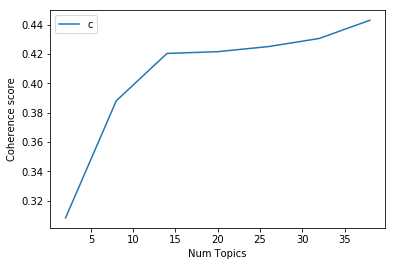

In [30]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3083
Num Topics = 8  has Coherence Value of 0.3881
Num Topics = 14  has Coherence Value of 0.4204
Num Topics = 20  has Coherence Value of 0.4216
Num Topics = 26  has Coherence Value of 0.425
Num Topics = 32  has Coherence Value of 0.4305
Num Topics = 38  has Coherence Value of 0.443


In [32]:
model_list

In [33]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.106*"এডিস" + 0.039*"না" + 0.036*"একটি" + 0.033*"কিন্তু" + 0.033*"তিনি" + '
  '0.029*"রোগের" + 0.025*"এমন" + 0.024*"ডেঙ্গুর" + 0.023*"কারণ" + '
  '0.018*"বিরুদ্ধে"'),
 (1,
  '0.084*"এ" + 0.072*"আক্রান্ত" + 0.055*"রক্ত" + 0.055*"একজন" + 0.039*"জন্য" + '
  '0.026*"খুব" + 0.022*"বছরের" + 0.021*"রক্তের_প্রয়োজন" + 0.017*"নেগেটিভ" + '
  '0.016*"৪_ব্যাগ"'),
 (2,
  '0.216*"ডেঙ্গু" + 0.094*"ঢাকা" + 0.058*"দুই" + 0.041*"ঢাকার" + 0.030*"লাখ" + '
  '0.018*"মন্ত্রী" + 0.013*"হাইকোর্ট" + 0.012*"প্রধানমন্ত্রী" + 0.011*"বলছেন" '
  '+ 0.011*"পরীক্ষায়"'),
 (3,
  '0.170*"হয়ে" + 0.135*"আক্রান্ত" + 0.074*"ডেঙ্গু" + 0.040*"মারা" + '
  '0.029*"বেড়েছে" + 0.025*"জ্বরের_প্রকোপ" + 0.024*"সুস্থ" + 0.021*"ঔষধ" + '
  '0.016*"সারাদেশে" + 0.014*"স্বাস্থ্য_অধিদপ্তর"'),
 (4,
  '0.062*"করে" + 0.058*"ভালো" + 0.042*"ডেঙ্গু" + 0.042*"তার" + '
  '0.028*"বাংলাদেশের" + 0.027*"কাজ" + 0.024*"গেছে" + 0.023*"বাড়ি" + '
  '0.022*"যেভাবে" + 0.015*"দিনেই"'),
 (5,
  '0.233*"ও" + 0.096*"প্রতিরোধ" + 0.052*"ডেঙ্গু" + 0.033*

In [34]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.0717,"আক্রান্ত, হয়েছে, এক, আরও, মৃত্যু, খবর, ডেঙ্গু...",ডেঙ্গু ডোঙ্গল লিখেছেন পোস্টটি করা হয়েছে ...
1,1,7.0,0.0681,"আক্রান্ত, হয়েছে, এক, আরও, মৃত্যু, খবর, ডেঙ্গু...",ডেঙ্গু ডোঙ্গল লিখেছেন আশাবাদী পোস্টটি করা হ...
2,2,15.0,0.0673,"জ্বর, ডেঙ্গু, এখন, কি, নাই, করবেন, হলে, তাহলে,...",আবার ডেঙ্গু জ্বর সতর্ক থাকুন
3,3,9.0,0.0697,"ডেঙ্গু, নতুন, স্বাস্থ্য, চিকিৎসা, বেড়ে, ধরনের...",24 ডেঙ্গু আক্রান্ত যুবরাজকে ছাড়াই নামছে ভারত
4,4,0.0,0.0932,"এডিস, না, একটি, কিন্তু, তিনি, রোগের, এমন, ডেঙ্...",ডেঙ্গু জ্বরের সেবাযত্ন ডেঙ্গু কি ১ডেঙ্গু এক...
5,5,0.0,0.0967,"এডিস, না, একটি, কিন্তু, তিনি, রোগের, এমন, ডেঙ্...",চারিদিকে প্রচুর ডেঙ্গু জ্বরের প্রকোপ বেড়ে...
6,6,2.0,0.0534,"ডেঙ্গু, ঢাকা, দুই, ঢাকার, লাখ, মন্ত্রী, হাইকোর...",ডেঙ্গু
7,7,0.0,0.0625,"এডিস, না, একটি, কিন্তু, তিনি, রোগের, এমন, ডেঙ্...",মশা দিয়ে মশা নিধন স্ত্রী এডিস মশার কামড়েই ...
8,8,7.0,0.0657,"আক্রান্ত, হয়েছে, এক, আরও, মৃত্যু, খবর, ডেঙ্গু...",ডেঙ্গু জ্বর রুখতে বিজ্ঞানীদের সাফল্য ডেঙ্গু ভ...
9,9,7.0,0.0636,"আক্রান্ত, হয়েছে, এক, আরও, মৃত্যু, খবর, ডেঙ্গু...",ডেঙ্গু জ্বর রুখতে বিজ্ঞানীদের সাফল্য ডেঙ্গু ভ...


In [35]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2040,"এডিস, না, একটি, কিন্তু, তিনি, রোগের, এমন, ডেঙ্...",এডিস মশা কখন কামড়ায় ডেঙ্গু জ্বরের জন্য দায়...
1,1.0,0.2213,"এ, আক্রান্ত, রক্ত, একজন, জন্য, খুব, বছরের, রক্...",ডেঙ্গু জ্বরে আক্রান্ত একজন মায়ের জন্য জরুরী ...
2,2.0,0.1485,"ডেঙ্গু, ঢাকা, দুই, ঢাকার, লাখ, মন্ত্রী, হাইকোর...",ঢাকা উত্তর ত্ত দক্ষিন এর সফল দুই চাষী ডেঙ্গু ...
3,3.0,0.2913,"হয়ে, আক্রান্ত, ডেঙ্গু, মারা, বেড়েছে, জ্বরের_...",ডাক্তাররা বলেছেন ডেঙ্গু আক্রান্ত কমাতে হলে ঔ...
4,4.0,0.2016,"করে, ভালো, ডেঙ্গু, তার, বাংলাদেশের, কাজ, গেছে,...",ঈদে যারা বাড়ি যাচ্ছেন তাদের ডেঙ্গু প্রতিরোধ...


In [36]:
df_dominant_topic.to_excel('F:\Python\Alvi\dominant.xlsx')

In [37]:
sent_topics_sorteddf_mallet.to_excel('F:\Python\Alvi\sent_topics_sorteddf_mallet.xlsx')